In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
shap.initjs()
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Get data

In [2]:
df = pd.read_csv("data/parser/group.csv")
df[["hdbscan", "kmeans"]] = df[["hdbscan", "kmeans"]].astype(int)
print(df.shape)
df.head(3)

(20, 19)


,整流器,項目,檢測日期,排流點電位_mv,自動回授電位_mv,接地棒阻抗_Ω,鈦陽極接地電阻A1_Ω,鈦陽極接地電阻A2_Ω,鈦陽極接地電阻A3_Ω,鈦陽極接地電阻A4_Ω,鈦陽極總接地電阻_Ω,本次電力_KWH,平均電力值_KWH/日,交流輸入_A,交流輸入_V,直流輸出_A,直流輸出_V,hdbscan,kmeans
0,24,109Q3,2020-07-21 00:00:00,-1447,-1348,6.32,4.56,4.52,4.65,5.91,4.28,3541,6.75,0.65,230.9,1.55,3.80,0,2
1,24,109Q4,2020-12-01 00:00:00,-1371,-1298,6.86,5.72,5.73,5.85,6.81,5.48,4303,5.73,1.74,231.6,1.81,1.87,0,2
2,24,110Q1,2021-01-22 00:00:00,-1492,-1318,3.20,2.28,2.33,2.35,3.64,2.22,4655,6.77,0.68,231.0,1.56,3.77,0,2


### Set lable and Add feature

In [3]:
df.insert(3, "季節", df["項目"].str[-1].astype(int)) # 增加季節特徵

# 設定label
df = df.drop("hdbscan", axis = 1)
df = df.rename(columns = {"kmeans": "label"})
df.head(3)

,整流器,項目,檢測日期,季節,排流點電位_mv,自動回授電位_mv,接地棒阻抗_Ω,鈦陽極接地電阻A1_Ω,鈦陽極接地電阻A2_Ω,鈦陽極接地電阻A3_Ω,鈦陽極接地電阻A4_Ω,鈦陽極總接地電阻_Ω,本次電力_KWH,平均電力值_KWH/日,交流輸入_A,交流輸入_V,直流輸出_A,直流輸出_V,label
0,24,109Q3,2020-07-21 00:00:00,3,-1447,-1348,6.32,4.56,4.52,4.65,5.91,4.28,3541,6.75,0.65,230.9,1.55,3.80,2
1,24,109Q4,2020-12-01 00:00:00,4,-1371,-1298,6.86,5.72,5.73,5.85,6.81,5.48,4303,5.73,1.74,231.6,1.81,1.87,2
2,24,110Q1,2021-01-22 00:00:00,1,-1492,-1318,3.20,2.28,2.33,2.35,3.64,2.22,4655,6.77,0.68,231.0,1.56,3.77,2


### Split data by rectifier

In [4]:
df24 = df.iloc[:10, 3:] # 整流器為24的資料
df25 = df.iloc[10:, 3:] # 整流器為25的資料

In [5]:
df24

,季節,排流點電位_mv,自動回授電位_mv,接地棒阻抗_Ω,鈦陽極接地電阻A1_Ω,鈦陽極接地電阻A2_Ω,鈦陽極接地電阻A3_Ω,鈦陽極接地電阻A4_Ω,鈦陽極總接地電阻_Ω,本次電力_KWH,平均電力值_KWH/日,交流輸入_A,交流輸入_V,直流輸出_A,直流輸出_V,label
0,3,-1447,-1348,6.32,4.56,4.52,4.65,5.91,4.28,3541,6.750000,0.65,230.9,1.55,3.800,2
1,4,-1371,-1298,6.86,5.72,5.73,5.85,6.81,5.48,4303,5.730000,1.74,231.6,1.81,1.870,2
2,1,-1492,-1318,3.20,2.28,2.33,2.35,3.64,2.22,4655,6.770000,0.68,231.0,1.56,3.770,2
3,2,-1217,-1182,6.82,5.43,5.65,6.73,7.44,5.36,5288,6.530000,0.84,235.0,2.10,3.760,0
4,3,-1457,-1198,1.10,1.79,2.61,2.84,3.19,2.19,5750,5.634146,0.74,230.2,1.75,3.770,0
5,4,-1456,-1294,3.96,2.72,2.70,2.77,4.53,2.68,6405,7.616279,0.76,228.6,1.89,3.892,0
6,1,-1473,-1287,2.56,2.27,2.23,2.26,3.45,2.03,7659,8.142857,0.70,233.6,1.48,3.731,1
7,2,-1429,-1272,2.52,2.44,2.42,2.41,3.84,2.28,8178,7.309859,0.73,232.0,1.72,3.726,1
8,3,-1467,-1287,0.74,3.52,3.58,3.60,5.12,3.43,8684,7.441176,0.71,232.4,1.75,3.741,1
9,4,-1498,-1360,0.57,3.48,3.37,3.56,5.20,3.63,9366,7.413043,0.71,224.8,1.78,1.817,1


In [6]:
df25

,季節,排流點電位_mv,自動回授電位_mv,接地棒阻抗_Ω,鈦陽極接地電阻A1_Ω,鈦陽極接地電阻A2_Ω,鈦陽極接地電阻A3_Ω,鈦陽極接地電阻A4_Ω,鈦陽極總接地電阻_Ω,本次電力_KWH,平均電力值_KWH/日,交流輸入_A,交流輸入_V,直流輸出_A,直流輸出_V,label
10,3,-1686,1605,53.20,2.08,2.03,2.01,1.99,1.85,19842,4.160000,0.96,230.2,3.92,2.360,1
11,4,-1598,-1421,59.70,2.27,2.01,1.95,1.98,1.87,20557,5.340000,1.07,228.3,4.88,2.300,2
12,1,-1645,-1539,5.98,3.72,2.65,2.93,2.99,2.97,20819,5.240000,0.91,229.5,0.32,2.280,2
13,2,-1413,-1402,3.72,5.15,5.23,5.27,5.18,4.94,21228,4.170000,1.15,230.0,4.87,2.390,2
14,3,-1518,-1498,5.93,2.66,1.85,1.83,1.90,1.39,21401,2.109756,0.73,229.3,2.69,2.010,2
15,4,-1312,-1336,7.65,2.28,2.21,2.27,2.36,2.09,21809,4.689655,0.53,229.6,1.39,0.873,0
16,1,-1390,-1321,2.73,1.58,1.47,1.35,1.42,1.12,22270,2.993506,0.41,233.8,0.49,0.860,0
17,2,-1340,-1321,2.32,2.02,1.98,1.87,1.92,1.75,22496,3.275362,0.41,228.3,0.61,0.945,0
18,3,-1364,-1201,0.45,1.01,0.97,0.95,0.97,0.87,22724,3.257143,0.67,230.6,2.43,1.500,0
19,4,-1408,-1360,3.94,0.97,0.96,0.98,0.95,0.83,23054,3.626374,0.59,232.6,1.38,1.443,0


### Scaling

In [7]:
num_feats = df25.columns[1:-1] # find numarical features

In [8]:
scaler = MinMaxScaler()
df25[num_feats] = scaler.fit_transform(df25[num_feats])
df24[num_feats] = scaler.fit_transform(df24[num_feats])

### Split X and Y

In [9]:
X_train24 = df24.drop("label", axis = 1)
X_train25 = df25.drop("label", axis = 1)

y_train24 = df24["label"]
y_train25 = df25["label"]

### Training model by rectifier

In [10]:
random_state = 99
xgb24 = XGBClassifier(random_state = random_state)
xgb24.fit(X_train24, y_train24)

xgb25 = XGBClassifier(random_state = random_state)
xgb25.fit(X_train25, y_train25)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

### Performance

In [11]:
names = ["整流器_24", "整流器_25"]
models = [xgb24, xgb25]
X_trains = [X_train24, X_train25]
y_trains = [y_train24, y_train25]

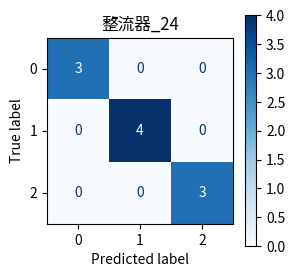

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

------------------------------------------------------------


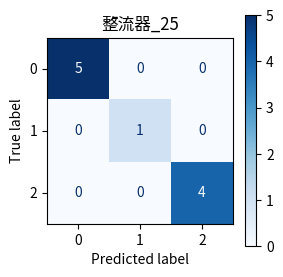

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

------------------------------------------------------------


,Accuracy,Recall,Precision,f1
整流器_24,1.0,1.0,1.0,1.0
整流器_25,1.0,1.0,1.0,1.0


In [12]:
score = []
for name, model, X_train, y_train in zip(names, models, X_trains, y_trains):
    # 預測
    pred = model.predict(X_train)
    
    # 計算分數
    acc  = accuracy_score(y_train, pred).round(2)
    recall  = recall_score(y_train, pred, average = 'weighted').round(2)
    precision  = precision_score(y_train, pred, average = 'weighted').round(2)
    f1 = f1_score(y_train, pred, average = 'weighted').round(2)

    # 儲存指標
    col1 = [acc, recall, precision, f1]
    col2 = ["Accuracy", "Recall", "Precision", "f1"]
    score.append(col1)
    
    # 輸出cunfusion matrix
    fig, ax = plt.subplots(figsize = (3, 3))
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_train, pred), display_labels = model.classes_)
    disp.plot(cmap = plt.cm.Blues, ax = ax)
    ax.set_title(name)
    plt.show()

    # 印出各類別的分數
    print(f"Classification Report:\n{classification_report(y_train, pred)}")
    print("-"*60)

score  = pd.DataFrame(score, index = names, columns = col2)
score

### Feature importance

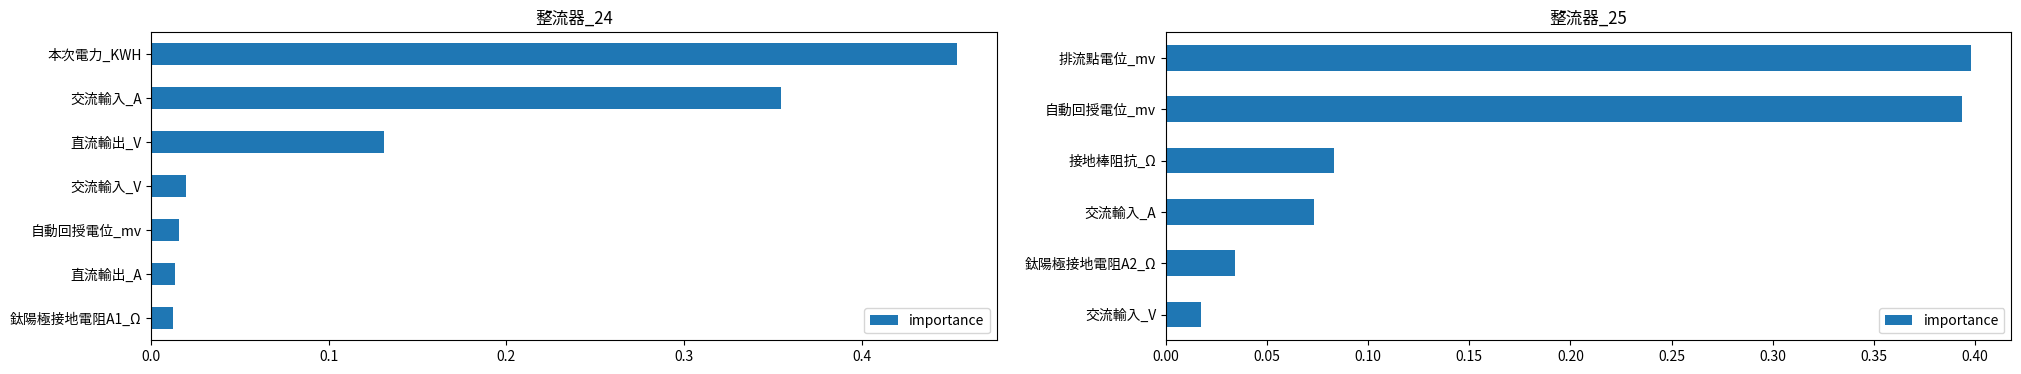

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (24, 4))
for i, (name, model, X_train) in enumerate(zip(names, models, X_trains)):
    imp = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns = ["importance"])
    imp = imp.sort_values("importance")
    imp = imp.query("importance != 0")
    imp.plot(kind = "barh", ax = ax[i])
    ax[i].set_title(name)

### Shap

In [14]:
explainer24 = shap.TreeExplainer(xgb24)
shap_values24 = explainer24.shap_values(X_train24)

explainer25 = shap.TreeExplainer(xgb25)
shap_values25 = explainer25.shap_values(X_train25)

shap_values = [shap_values24, shap_values25]

print(shap_values24[0].shape, shap_values24[1].shape, shap_values24[2].shape)
print(shap_values25[0].shape, shap_values25[1].shape, shap_values25[2].shape)

(10, 15) (10, 15) (10, 15)
(10, 15) (10, 15) (10, 15)


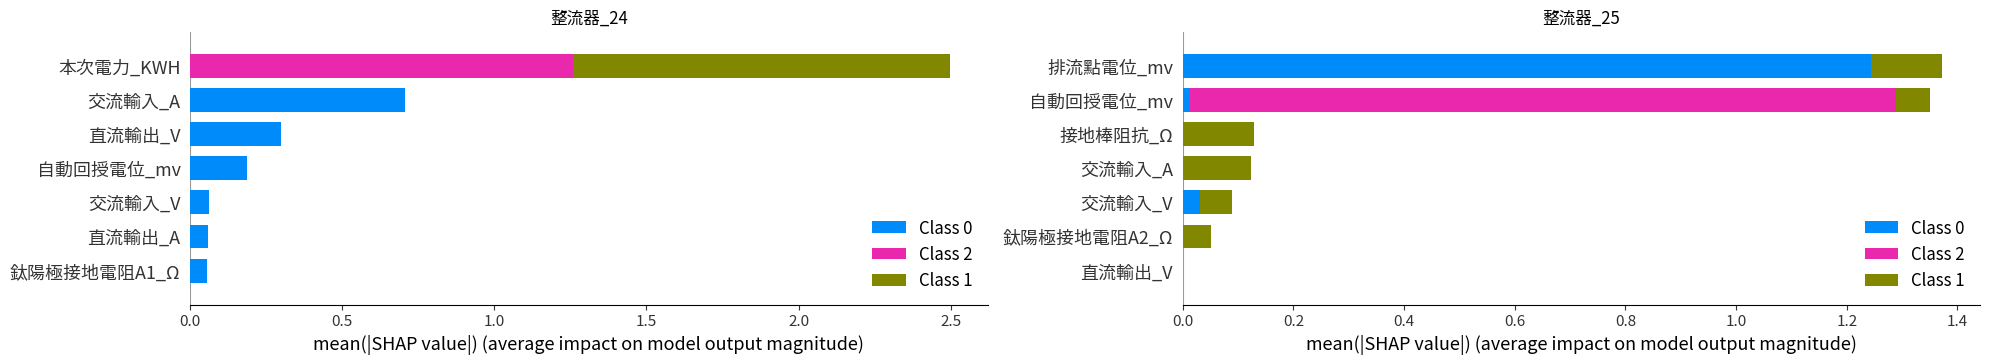

In [15]:
plt.figure(figsize=(20, 10))
for j, (name, shap_value, X_train) in enumerate(zip(names, shap_values, X_trains)):
    plt.subplot(3, 2, j+1)
    shap.summary_plot(shap_value, X_train, plot_size=None, max_display = 7, show=False)
    plt.title(f"{name}")

# 整流器24:
#   類別0主要使用交流輸入A、直流輸出V、自動回授電位、交流輸入V、直流輸出A、鈦陽極接地電阻A1來做分類
#   類別1主要使用本次電力來做分類
#   類別2主要使用本次電力來做分類

# 整流器25:
#   類別0主要使用排流點電位、交流輸入V和自動回授電位來做分類
#   類別1主要使用接地棒阻抗、排流點電位、交流輸入A、自動回授電位、交流輸入V、鈦陽極接地電阻A2來做分類
#   類別2主要使用自動回授電位來做分類

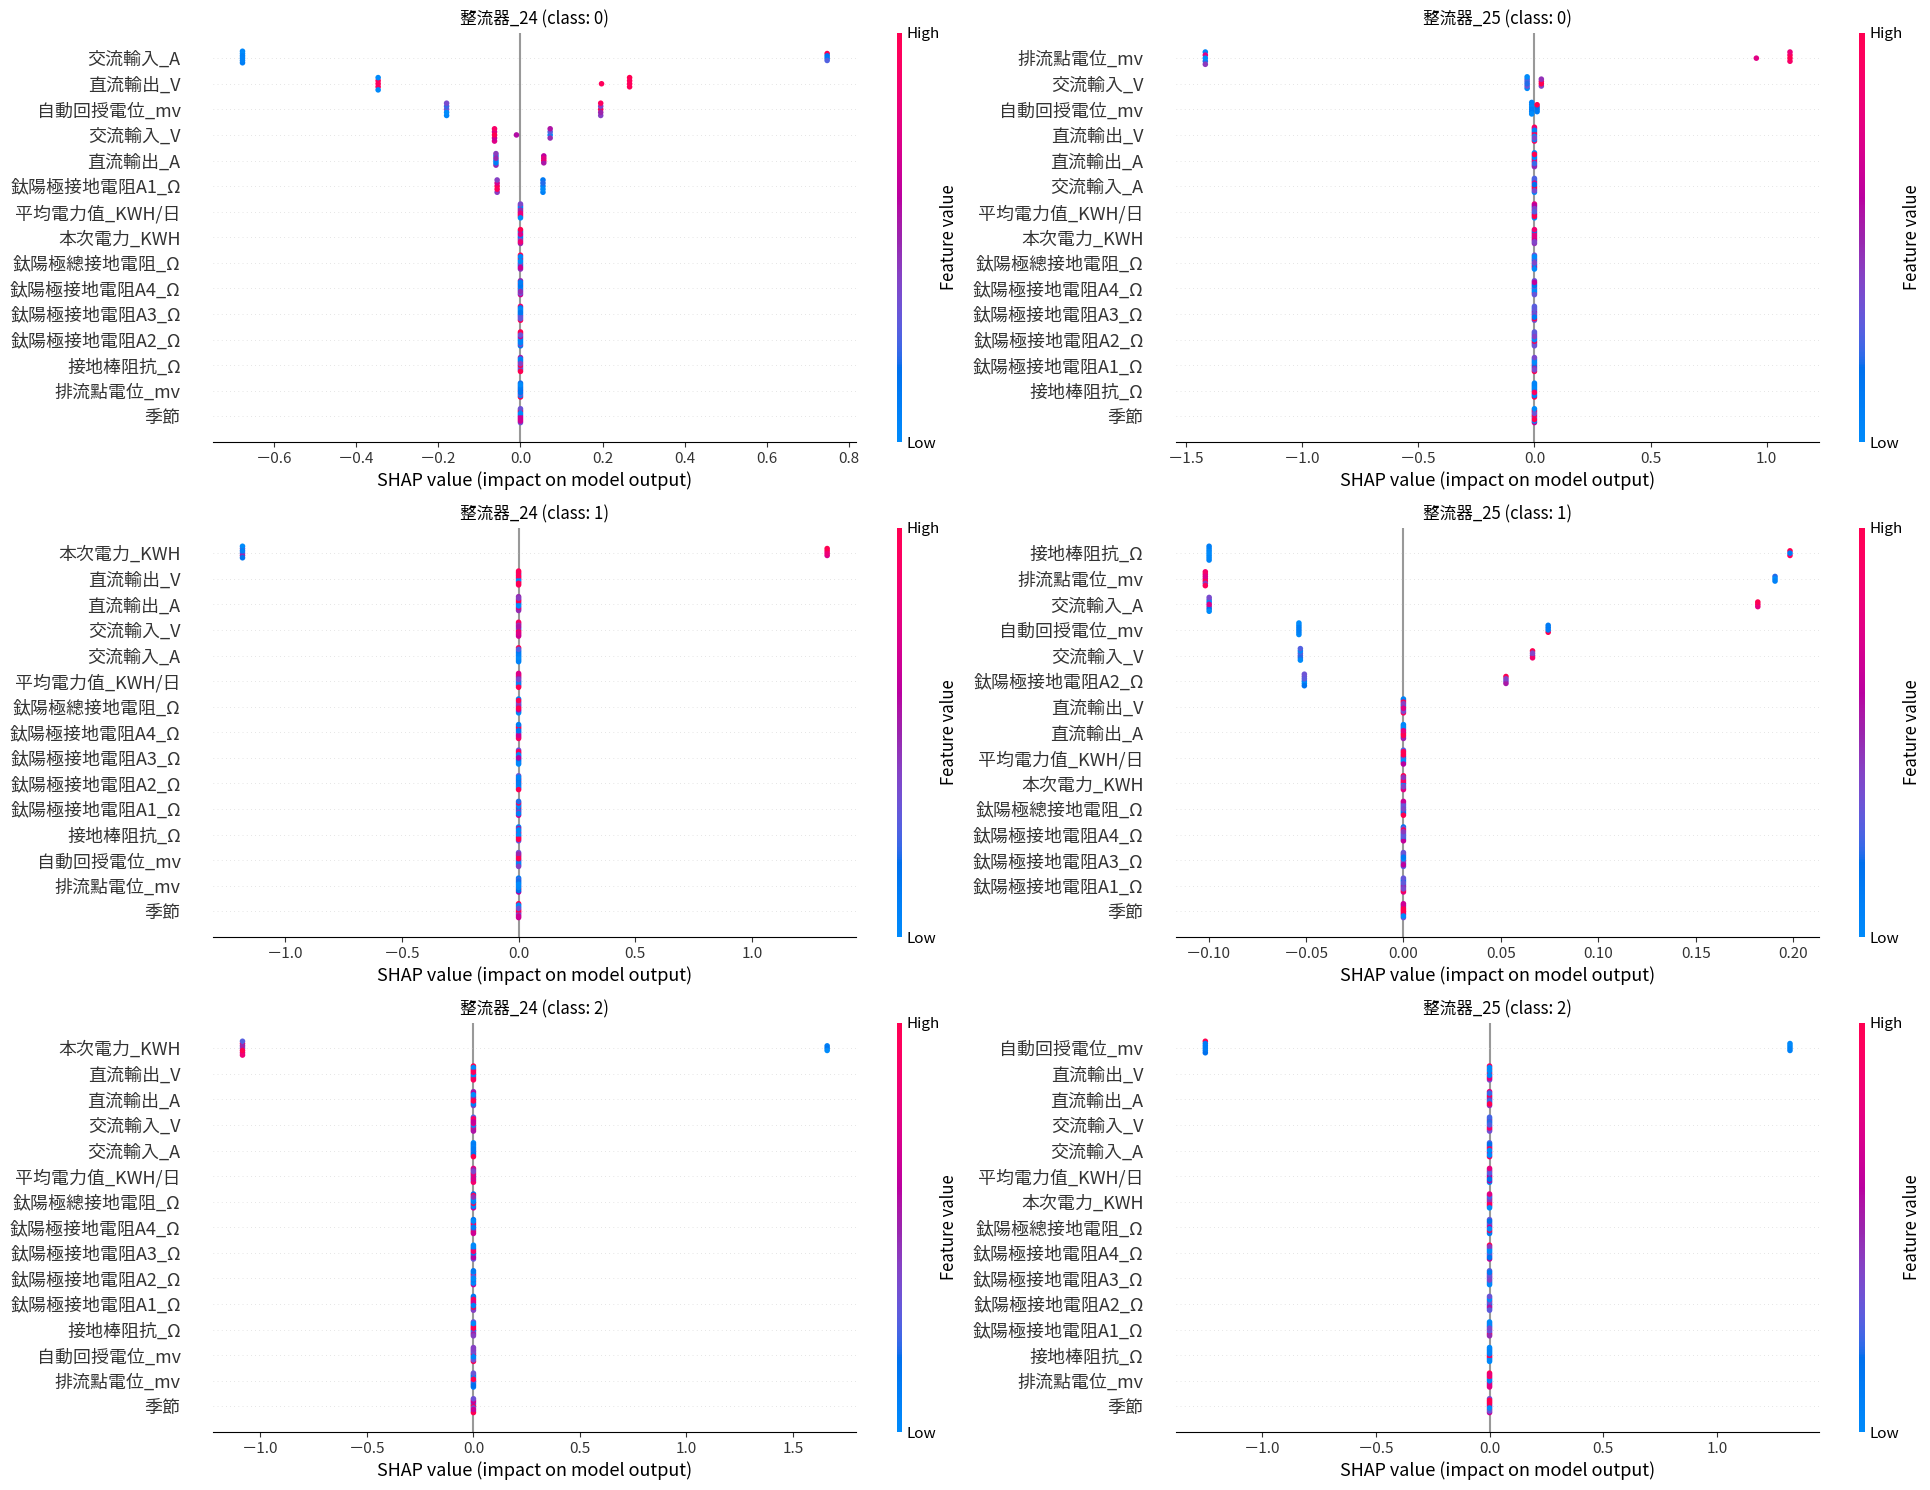

In [16]:
plt.figure(figsize=(20, 15))
for label in range(3):
    for j, (name, shap_value, X_train) in enumerate(zip(names, shap_values, X_trains)):
        num = label*2 + (j+1)
        plt.subplot(3, 2, num)
        shap.summary_plot(shap_value[label], X_train, plot_size = None, show = False)
        plt.title(f"{name} (class: {label})")

In [17]:
name = "整流器-24"
idx = 8
label = 0
print(f"{name}, 第{idx}個樣本, 類別{label}")
shap.force_plot(explainer24.expected_value[label], shap_values24[label][idx], X_train24.iloc[idx])

整流器-24, 第8個樣本, 類別0


In [18]:
label = 1
print(f"{name}, 第{idx}個樣本, 類別{label}")
shap.force_plot(explainer24.expected_value[label], shap_values24[label][idx], X_train24.iloc[idx])

整流器-24, 第8個樣本, 類別1


In [19]:
label = 2
print(f"{name}, 第{idx}個樣本, 類別{label}")
shap.force_plot(explainer24.expected_value[label], shap_values24[label][idx], X_train24.iloc[idx])

整流器-24, 第8個樣本, 類別2


In [20]:
label = 0
shap.force_plot(explainer25.expected_value[label], shap_values25[label], X_train)